In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.utils import shuffle
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
import matplotlib
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
import os
import time
import numpy as np
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, KFold, RepeatedKFold
import lightgbm as lgb
sns.set()
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import warnings
warnings.filterwarnings("ignore")

In [2]:
train=pd.read_csv("../input/X_train.csv")
train.head()

,row_id,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z
0,0_0,0,0,-0.75853,-0.63435,-0.10488,-0.10597,0.107650,0.017561,0.000767,-0.74857,2.1030,-9.7532
1,0_1,0,1,-0.75853,-0.63434,-0.10490,-0.10600,0.067851,0.029939,0.003385,0.33995,1.5064,-9.4128
2,0_2,0,2,-0.75853,-0.63435,-0.10492,-0.10597,0.007275,0.028934,-0.005978,-0.26429,1.5922,-8.7267
3,0_3,0,3,-0.75852,-0.63436,-0.10495,-0.10597,-0.013053,0.019448,-0.008974,0.42684,1.0993,-10.0960
4,0_4,0,4,-0.75852,-0.63435,-0.10495,-0.10596,0.005135,0.007652,0.005245,-0.50969,1.4689,-10.4410


In [3]:
test=pd.read_csv("../input/X_test.csv")
test.head()

,row_id,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z
0,0_0,0,0,-0.025773,-0.98864,-0.14801,0.003350,-0.006524,-0.001071,-0.027390,0.10043,4.2061,-5.5439
1,0_1,0,1,-0.025683,-0.98862,-0.14816,0.003439,-0.113960,0.083987,-0.060590,-0.70889,3.9905,-8.0273
2,0_2,0,2,-0.025617,-0.98861,-0.14826,0.003571,-0.080518,0.114860,-0.037177,1.45710,2.2828,-11.2990
3,0_3,0,3,-0.025566,-0.98862,-0.14817,0.003609,0.070067,0.033820,-0.035904,0.71096,1.8582,-12.2270
4,0_4,0,4,-0.025548,-0.98866,-0.14792,0.003477,0.152050,-0.029016,-0.015314,3.39960,2.7881,-10.4100


In [4]:
sample_submission=pd.read_csv("../input/sample_submission.csv")
sample_submission.head()

,series_id,surface
0,0,concrete
1,1,concrete
2,2,concrete
3,3,concrete
4,4,concrete


In [5]:
test_id=sample_submission['series_id']
y_train=pd.read_csv("../input/y_train.csv")
y_train.head()

,series_id,group_id,surface
0,0,13,fine_concrete
1,1,31,concrete
2,2,20,concrete
3,3,31,concrete
4,4,22,soft_tiles


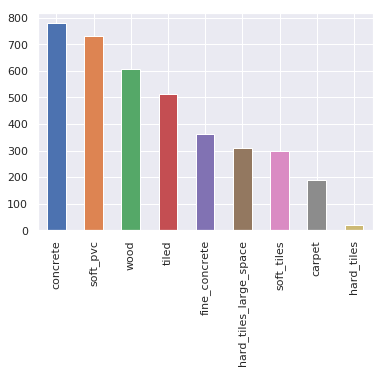

In [6]:
y_train['surface'].value_counts().plot.bar();

In [7]:
train.shape,test.shape,y_train.shape

((487680, 13), (488448, 13), (3810, 3))

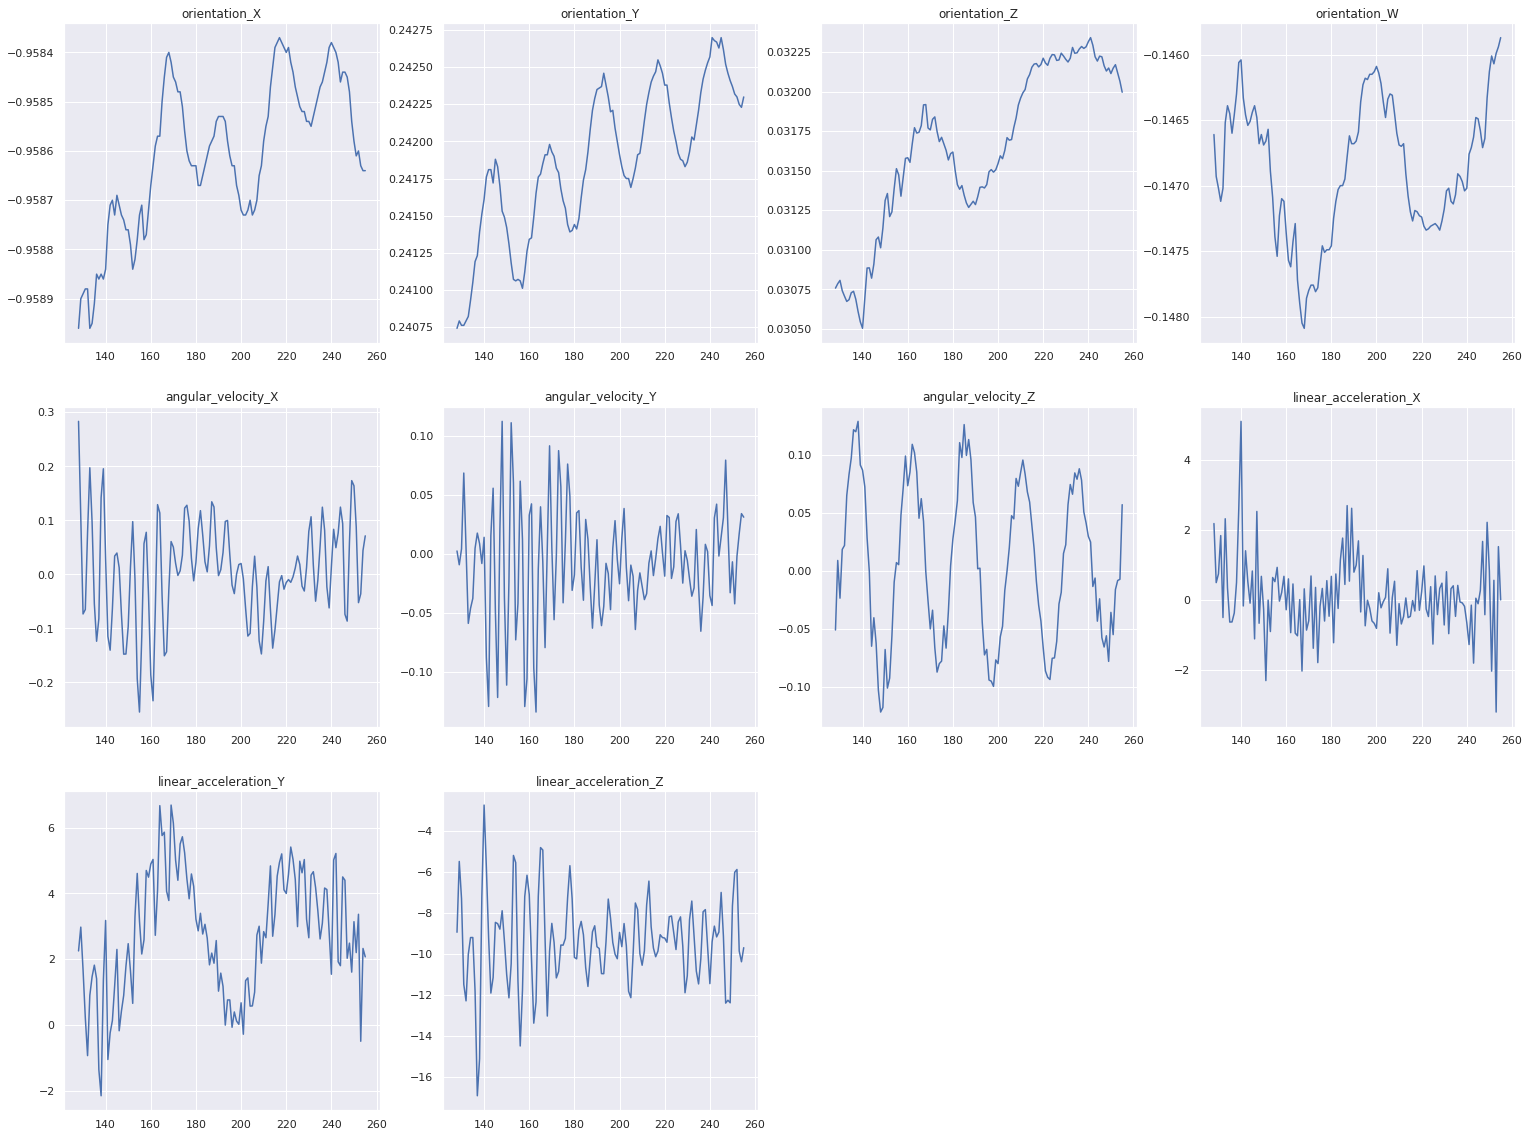

In [8]:
plt.figure(figsize=(26, 20))
for i, col in enumerate(train.columns[3:]):
    plt.subplot(3, 4, i + 1)
    plt.plot(train.loc[train['series_id'] == 1, col])
    plt.title(col)

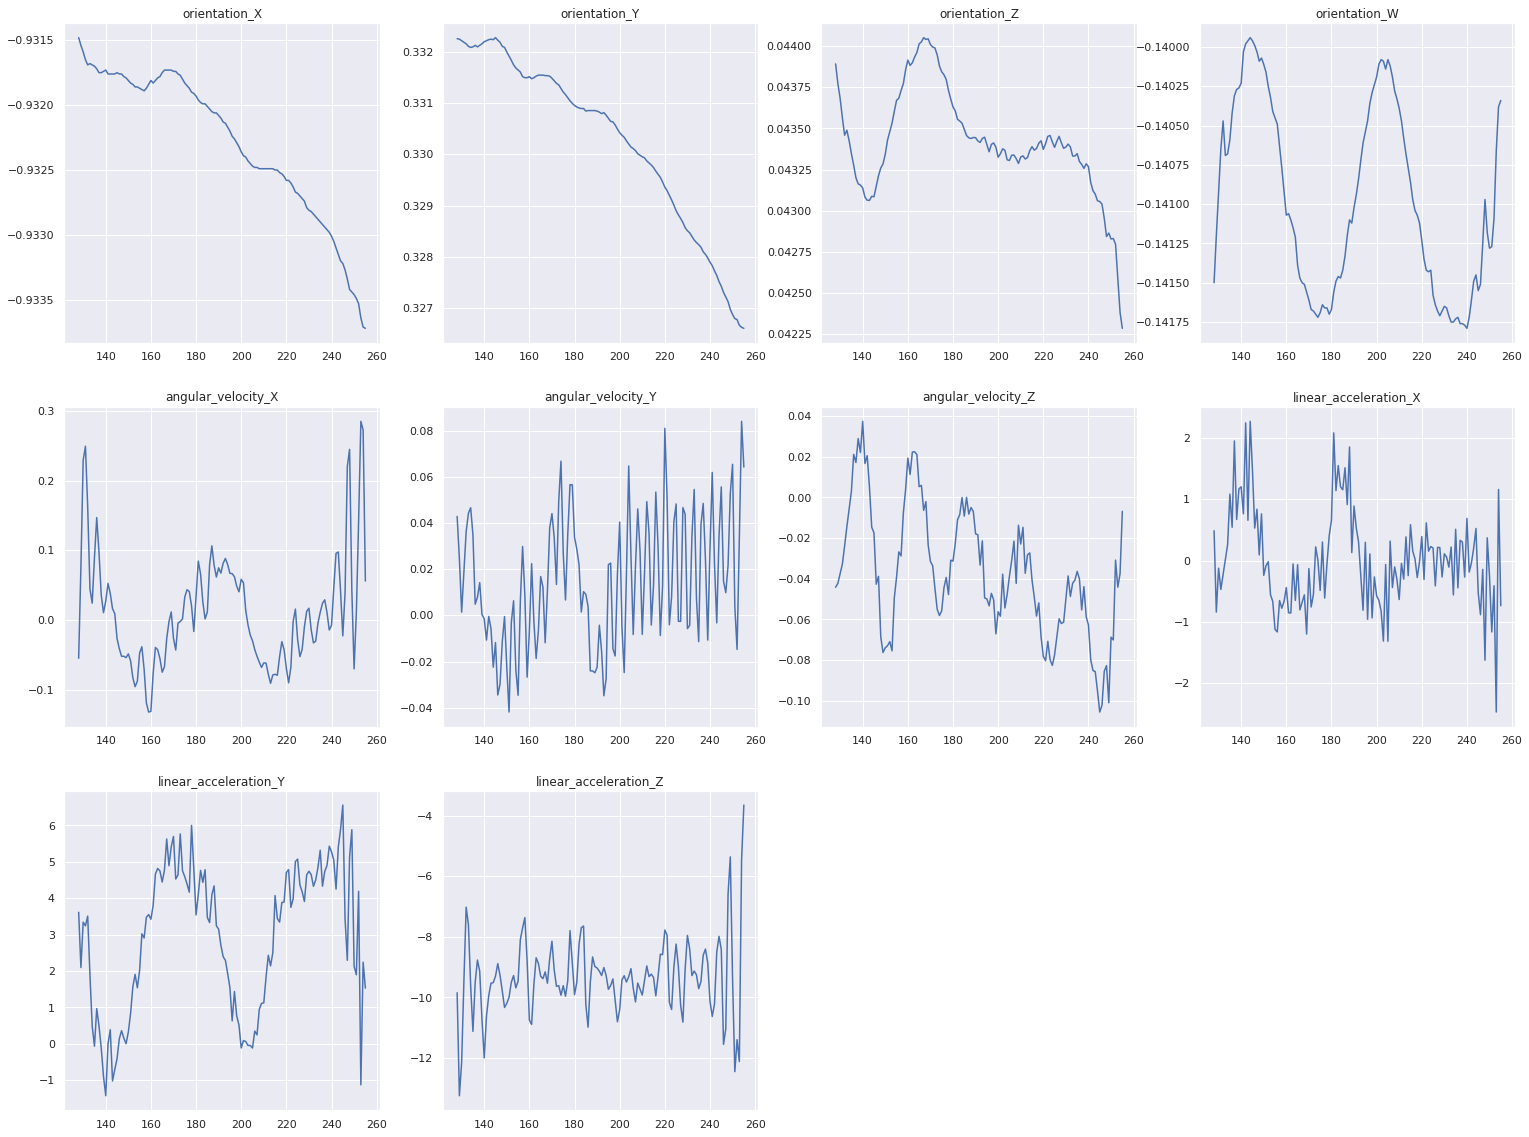

In [9]:
plt.figure(figsize=(26, 20))
for i, col in enumerate(test.columns[3:]):
    plt.subplot(3, 4, i + 1)
    plt.plot(test.loc[test['series_id'] == 1, col])
    plt.title(col)

## Feature engineering

In [10]:
# refrence from https://www.kaggle.com/jsaguiar/surface-recognition-baseline
def feature_extraction(raw_frame):
    frame = pd.DataFrame()
    raw_frame['angular_velocity'] = raw_frame['angular_velocity_X'] + raw_frame['angular_velocity_Y'] + raw_frame['angular_velocity_Z']
    raw_frame['linear_acceleration'] = raw_frame['linear_acceleration_X'] + raw_frame['linear_acceleration_Y'] + raw_frame['linear_acceleration_Y']
    raw_frame['velocity_to_acceleration'] = raw_frame['angular_velocity'] / raw_frame['linear_acceleration']
    
    for col in raw_frame.columns[3:]:
        frame[col + '_mean'] = raw_frame.groupby(['series_id'])[col].mean()
        frame[col + '_std'] = raw_frame.groupby(['series_id'])[col].std()
        frame[col + '_max'] = raw_frame.groupby(['series_id'])[col].max()
        frame[col + '_min'] = raw_frame.groupby(['series_id'])[col].min()
        frame[col + '_max_to_min'] = frame[col + '_max'] / frame[col + '_min']
        
        frame[col + '_mean_abs_change'] = raw_frame.groupby('series_id')[col].apply(lambda x: np.mean(np.abs(np.diff(x))))
        frame[col + '_abs_max'] = raw_frame.groupby('series_id')[col].apply(lambda x: np.max(np.abs(x)))
    return frame

In [11]:
train_df = feature_extraction(train)
test_df = feature_extraction(test)
train_df.head()

,orientation_X_mean,orientation_X_std,orientation_X_max,orientation_X_min,orientation_X_max_to_min,orientation_X_mean_abs_change,orientation_X_abs_max,orientation_Y_mean,orientation_Y_std,orientation_Y_max,orientation_Y_min,orientation_Y_max_to_min,orientation_Y_mean_abs_change,orientation_Y_abs_max,orientation_Z_mean,orientation_Z_std,orientation_Z_max,orientation_Z_min,orientation_Z_max_to_min,orientation_Z_mean_abs_change,orientation_Z_abs_max,orientation_W_mean,orientation_W_std,orientation_W_max,orientation_W_min,orientation_W_max_to_min,orientation_W_mean_abs_change,orientation_W_abs_max,angular_velocity_X_mean,angular_velocity_X_std,angular_velocity_X_max,angular_velocity_X_min,angular_velocity_X_max_to_min,angular_velocity_X_mean_abs_change,angular_velocity_X_abs_max,angular_velocity_Y_mean,angular_velocity_Y_std,angular_velocity_Y_max,angular_velocity_Y_min,angular_velocity_Y_max_to_min,...,linear_acceleration_X_max,linear_acceleration_X_min,linear_acceleration_X_max_to_min,linear_acceleration_X_mean_abs_change,linear_acceleration_X_abs_max,linear_acceleration_Y_mean,linear_acceleration_Y_std,linear_acceleration_Y_max,linear_acceleration_Y_min,linear_acceleration_Y_max_to_min,linear_acceleration_Y_mean_abs_change,linear_acceleration_Y_abs_max,linear_acceleration_Z_mean,linear_acceleration_Z_std,linear_acceleration_Z_max,linear_acceleration_Z_min,linear_acceleration_Z_max_to_min,linear_acceleration_Z_mean_abs_change,linear_acceleration_Z_abs_max,angular_velocity_mean,angular_velocity_std,angular_velocity_max,angular_velocity_min,angular_velocity_max_to_min,angular_velocity_mean_abs_change,angular_velocity_abs_max,linear_acceleration_mean,linear_acceleration_std,linear_acceleration_max,linear_acceleration_min,linear_acceleration_max_to_min,linear_acceleration_mean_abs_change,linear_acceleration_abs_max,velocity_to_acceleration_mean,velocity_to_acceleration_std,velocity_to_acceleration_max,velocity_to_acceleration_min,velocity_to_acceleration_max_to_min,velocity_to_acceleration_mean_abs_change,velocity_to_acceleration_abs_max
series_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,-0.758666,0.000363,-0.75822,-0.75953,0.998275,0.000015,0.75953,-0.634008,0.000471,-0.63306,-0.63456,0.997636,0.000018,0.63456,-0.105474,0.000432,-0.104610,-0.106140,0.985585,0.000051,0.106140,-0.106470,0.000389,-0.105590,-0.107050,0.986362,0.000042,0.107050,-0.002481,0.052800,0.107650,-0.16041,-0.671093,0.029984,0.16041,-0.003306,0.031544,0.072698,-0.079404,-0.915546,...,2.85380,-1.8644,-1.530680,0.714580,2.8538,2.984195,1.387790,5.3864,0.075417,71.421563,0.558104,5.3864,-9.320391,1.095040,-6.2681,-12.512,0.500967,0.810443,12.512,0.001745,0.054317,0.125978,-0.194071,-0.649136,0.037111,0.194071,6.231808,3.183764,12.03250,-0.027290,-440.912422,1.507869,12.03250,0.023497,0.222562,2.444038,-0.163152,-14.980095,0.057500,2.444038
1,-0.958606,0.000151,-0.95837,-0.95896,0.999385,0.000023,0.95896,0.241867,0.000499,0.24270,0.24074,1.008142,0.000070,0.24270,0.031650,0.000508,0.032341,0.030504,1.060222,0.000048,0.032341,-0.146876,0.000521,-0.145870,-0.148090,0.985009,0.000103,0.148090,0.004605,0.092309,0.283420,-0.25480,-1.112323,0.063036,0.28342,-0.007757,0.046523,0.112080,-0.134330,-0.834363,...,5.10020,-3.1934,-1.597107,1.242063,5.1002,2.768193,1.864457,6.6850,-2.149200,-3.110460,1.019259,6.6850,-9.388899,2.123065,-2.7449,-16.928,0.162151,1.625696,16.928,0.003054,0.114295,0.279769,-0.302061,-0.926201,0.072905,0.302061,5.658253,3.798361,12.51448,-4.179540,-2.994224,2.680602,12.51448,0.006958,0.115248,1.157278,-0.258428,-4.478137,0.057504,1.157278
2,-0.512057,0.001377,-0.50944,-0.51434,0.990473,0.000041,0.51434,-0.846171,0.000785,-0.84490,-0.84779,0.996591,0.000024,0.84779,-0.129371,0.000541,-0.128520,-0.130300,0.986339,0.000059,0.130300,-0.071082,0.000278,-0.070378,-0.071535,0.983826,0.000044,0.071535,0.002646,0.060168,0.141920,-0.15271,-0.929343,0.029703,0.15271,-0.009232,0.035530,0.091946,-0.107810,-0.852852,...,1.8

In [12]:
train_df.shape,test_df.shape

((3810, 91), (3816, 91))

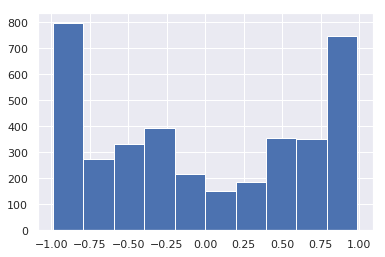

In [13]:
train_df["orientation_X_mean"].hist()

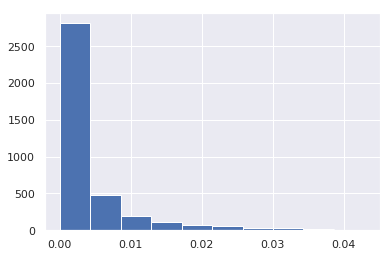

In [14]:
train_df["orientation_X_std"].hist()

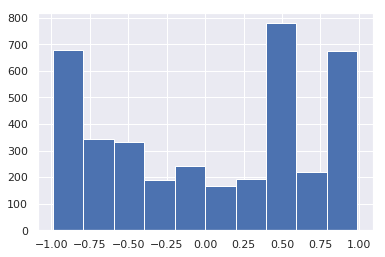

In [15]:
test_df["orientation_X_mean"].hist()

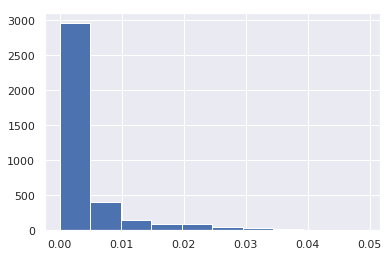

In [16]:
test_df["orientation_X_std"].hist()

In [17]:
le = LabelEncoder()
target_train = le.fit_transform(y_train['surface'])

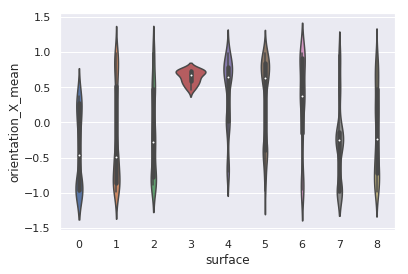

In [18]:
train_df['surface']=target_train
sns.violinplot(data=train_df,x="surface", y="orientation_X_mean")

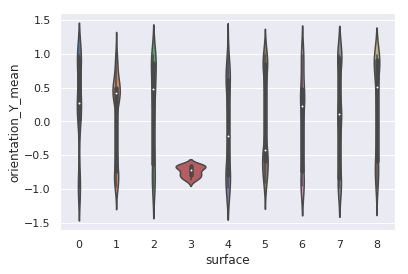

In [19]:
sns.violinplot(data=train_df,x="surface", y="orientation_Y_mean")

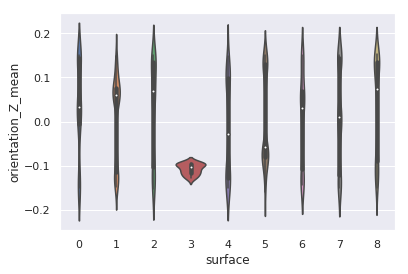

In [20]:
sns.violinplot(data=train_df,x="surface", y="orientation_Z_mean")

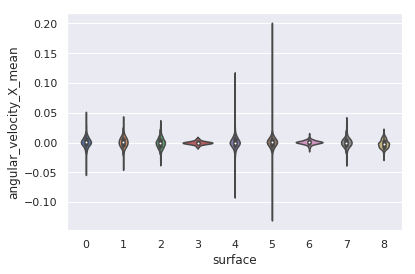

In [21]:
sns.violinplot(data=train_df,x="surface", y="angular_velocity_X_mean")

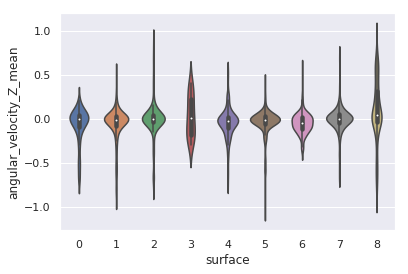

In [22]:
sns.violinplot(data=train_df,x="surface", y="angular_velocity_Z_mean")

In [23]:
train_df=train_df.drop(['surface'],axis=1)

## first We are going to split the data and then we will see how the different models works..

In [24]:
X_train, X_test, Y_train, Y_test = train_test_split(train_df, target_train, random_state = 0)
X_train.shape,X_test.shape

((2857, 91), (953, 91))

In [25]:
sc=StandardScaler()
X_train=sc.fit_transform(X_train)
X_test=sc.transform(X_test)

In [26]:
preds = []
K = 12
kf = KFold(n_splits = K, random_state = 3228, shuffle = True)

## RandomForestClassifier with k-fold

In [27]:
alg =  RandomForestClassifier()

In [28]:
for train_index, test_index in kf.split(X_train):
    train_X, valid_X = X_train[train_index], X_train[test_index]
    train_y, valid_y = Y_train[train_index], Y_train[test_index]
    alg.fit( train_X,  train_y)                   
    pred = alg.predict(X_test)
    preds.append(list(pred))

In [29]:
predx=[]
for i in range(len(preds[0])):
    sum=[]
    for j in range(K):
        sum.append(preds[j][i])
            
    predx.append(max(set(sum), key =sum.count))

In [30]:
accuracy_score(Y_test, predx)

0.8646379853095488

## confusion_matrix

In [31]:
cm = confusion_matrix(Y_test, predx)
cm 

array([[ 39,   7,   0,   0,   0,   0,   2,   1,   3],
       [  3, 161,   3,   0,   2,   3,   3,   1,   4],
       [  0,   7,  65,   0,   1,   5,   1,   3,   4],
       [  0,   0,   0,   5,   0,   0,   0,   0,   2],
       [  1,   4,   2,   0,  68,   1,   0,   0,   1],
       [  0,   8,   0,   0,   2, 177,   2,   0,   4],
       [  1,   2,   1,   0,   0,   1,  70,   0,   0],
       [  2,   5,   1,   0,   2,   3,   1, 112,   3],
       [  2,   7,   4,   0,   0,   8,   1,   5, 127]])

# LightGBM

In [32]:
params = {
    'num_leaves': 20,
    'min_data_in_leaf': 15,
    'objective': 'multiclass',
    'max_depth': 8,
    'learning_rate': 0.01,
    "boosting": "gbdt",
    "bagging_freq": 5,
    "bagging_fraction": 0.8126672064208567,
    "bagging_seed": 11,
    "verbosity": -1,
    'reg_alpha': 0.1302650970728192,
    'reg_lambda': 0.3603427518866501,
    "num_class": 9,
    'nthread': -1
}

def multiclass_accuracy(preds, train_data):
    labels = train_data.get_label()
    pred_class = np.argmax(preds.reshape(9, -1).T, axis=1)
    return 'multi_accuracy', np.mean(labels == pred_class), True

t0 = time.time()
train_set = lgb.Dataset(X_train, label=Y_train)
eval_hist = lgb.cv(params, train_set, nfold=8, num_boost_round=1200,
                   early_stopping_rounds=80, seed=19, feval=multiclass_accuracy)
num_rounds = len(eval_hist['multi_logloss-mean'])
# retrain the model and make predictions for test set
clf = lgb.train(params, train_set, num_boost_round=num_rounds)
predictions = clf.predict(X_test, num_iteration=None)
print("Timer: {:.1f}s".format(time.time() - t0))

Timer: 323.2s


In [33]:
idx = predictions.argmax(axis=1)
y_pred1 = (idx[:,None] == np.arange(predictions.shape[1])).astype(int)
y_pred1

array([[0, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 1, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0]])

In [34]:
y_pred1 = [np.where(r == 1)[0][0] for r in y_pred1]

## accuracy_score

In [35]:
accuracy_score(Y_test, y_pred1)

0.8856243441762854

## confusion_matrix

In [36]:
cm = confusion_matrix(Y_test, y_pred1)
cm 

array([[ 40,   8,   0,   0,   1,   0,   0,   0,   3],
       [  1, 162,   1,   0,   3,   1,   3,   4,   5],
       [  0,   7,  64,   0,   2,   4,   1,   2,   6],
       [  0,   0,   0,   5,   0,   0,   0,   0,   2],
       [  0,   2,   3,   0,  70,   1,   1,   0,   0],
       [  0,   5,   0,   0,   2, 182,   1,   0,   3],
       [  0,   3,   0,   0,   0,   2,  70,   0,   0],
       [  1,   3,   0,   0,   0,   0,   1, 122,   2],
       [  0,  12,   4,   0,   0,   5,   0,   4, 129]])

## Deep Learning with k-fold

In [37]:
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.optimizers import SGD

Using TensorFlow backend.


## Transform Y_train into onehot encoded form

In [38]:
Y_traind = np.zeros((2857, 9))
Y_traind[np.arange(2857), Y_train] = 1
Y_traind

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 1., ..., 0., 0., 0.]])

In [39]:
predsd = []
K = 3
kf = KFold(n_splits = K, random_state = 3228, shuffle = True)

In [40]:
for train_index, test_index in kf.split(X_train):
    train_X, valid_X = X_train[train_index], X_train[test_index]
    train_y, valid_y = Y_train[train_index], Y_train[test_index]
    classifier = Sequential()
    classifier.add(Dense(output_dim = 100, init = 'uniform', activation = 'relu', input_dim = 91))
    classifier.add(Dropout(0.1))
    classifier.add(Dense(output_dim = 60, init = 'uniform', activation = 'relu'))
    classifier.add(Dropout(0.1))
    classifier.add(Dense(output_dim = 40, init = 'uniform', activation = 'relu'))
    classifier.add(Dense(output_dim = 9, init = 'uniform', activation = 'softmax'))
    classifier.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
    classifier.fit(X_train,Y_traind, nb_epoch = 130)
    pred = classifier.predict(X_test)
    predsd.append(list(pred))

Epoch 1/130
2857/2857 [==============================] - 0s 171us/step - loss: 1.8990 - acc: 0.3602
Epoch 2/130
2857/2857 [==============================] - 0s 58us/step - loss: 1.6115 - acc: 0.4078
Epoch 3/130
2857/2857 [==============================] - 0s 53us/step - loss: 1.4647 - acc: 0.4459
Epoch 4/130
2857/2857 [==============================] - 0s 51us/step - loss: 1.3516 - acc: 0.4883
Epoch 5/130
2857/2857 [==============================] - 0s 51us/step - loss: 1.2461 - acc: 0.5324
Epoch 6/130
2857/2857 [==============================] - 0s 52us/step - loss: 1.1818 - acc: 0.5632
Epoch 7/130
2857/2857 [==============================] - 0s 52us/step - loss: 1.1274 - acc: 0.5884
Epoch 8/130
2857/2857 [==============================] - 0s 52us/step - loss: 1.0563 - acc: 0.6188
Epoch 9/130
2857/2857 [==============================] - 0s 52us/step - loss: 1.0120 - acc: 0.6409
Epoch 10/130
2857/2857 [==============================] - 0s 52us/step - loss: 0.9553 - acc: 0.6559
Epoch 11

In [41]:
f=0
for i in range(K):
    a=predsd[i]
    f+=np.array(a)
f=f/K; 
f=np.array(f)

In [42]:
idx = f.argmax(axis=1)
y_predx = (idx[:,None] == np.arange(f.shape[1])).astype(int)
y_predx

array([[0, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 1, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0]])

In [43]:
y_predx = [np.where(r == 1)[0][0] for r in y_predx]

## accuracy_score from deep learning

In [44]:
accuracy_score(Y_test, y_predx)

0.8394543546694648

## confusion_matrix

In [45]:
cm = confusion_matrix(Y_test, y_predx)
cm

array([[ 38,   5,   0,   0,   2,   2,   0,   2,   3],
       [  2, 157,   4,   0,   6,   4,   1,   5,   1],
       [  1,   1,  65,   0,   5,   3,   0,   4,   7],
       [  0,   0,   0,   7,   0,   0,   0,   0,   0],
       [  2,   2,   2,   0,  68,   1,   1,   0,   1],
       [  2,   5,   5,   0,   2, 171,   1,   0,   7],
       [  1,   1,   0,   0,   0,   4,  66,   0,   3],
       [  1,   5,   4,   0,   1,   2,   1, 107,   8],
       [  1,   6,   6,   2,   0,  11,   1,   6, 121]])

## Combined all 3 model

In [46]:
lt=[y_predx,y_pred1,predx]

## y_predx from deeplearning
##y_pred1 from lightgbm
##predx from randomforest

In [47]:
predx=[]
for i in range(len(lt[0])):
    sum=[]
    for j in range(3):
        
        sum.append(lt[j][i])
            
    predx.append(max(set(sum), key =sum.count))

## accuracy_score from combined model

In [48]:
accuracy_score(Y_test, predx)

0.8856243441762854

## lightgbm provides here some better result than randomforest and deeplearning

In [49]:
params = {
    'num_leaves': 20,
    'min_data_in_leaf': 15,
    'objective': 'multiclass',
    'max_depth': 10,
    'learning_rate': 0.01,
    "boosting": "gbdt",
    "bagging_freq": 5,
    "bagging_fraction": 0.8126672064208567,
    "bagging_seed": 11,
    "verbosity": -1,
    'reg_alpha': 0.1302650970728192,
    'reg_lambda': 0.3603427518866501,
    "num_class": 9,
    'nthread': -1
}

def multiclass_accuracy(preds, train_data):
    labels = train_data.get_label()
    pred_class = np.argmax(preds.reshape(9, -1).T, axis=1)
    return 'multi_accuracy', np.mean(labels == pred_class), True

t0 = time.time()
train_set = lgb.Dataset(train_df, label=target_train)
eval_hist = lgb.cv(params, train_set, nfold=20, num_boost_round=1400,
                   early_stopping_rounds=80, seed=19, feval=multiclass_accuracy)
num_rounds = len(eval_hist['multi_logloss-mean'])
# retrain the model and make predictions for test set
clf = lgb.train(params, train_set, num_boost_round=num_rounds)
predictions = clf.predict(test_df, num_iteration=None)
print("Timer: {:.1f}s".format(time.time() - t0))

Timer: 1034.2s


In [50]:
predictions

array([[4.80750471e-03, 9.67628973e-03, 8.22492283e-02, ...,
        6.63575305e-04, 8.63742086e-02, 3.12525389e-03],
       [2.55283235e-01, 5.43670464e-01, 2.05039312e-02, ...,
        7.09011870e-03, 8.97241740e-03, 3.09687029e-02],
       [1.01998835e-03, 1.34319252e-02, 2.11467369e-02, ...,
        8.68894093e-04, 9.34252245e-01, 2.40914624e-02],
       ...,
       [7.55556751e-03, 5.43635506e-01, 6.68004337e-02, ...,
        5.70746467e-03, 2.08844393e-02, 8.89017038e-02],
       [4.63158243e-02, 7.60084347e-01, 3.93255874e-03, ...,
        1.79667060e-03, 1.39170849e-02, 1.60690322e-01],
       [4.75522686e-03, 7.53057836e-04, 3.14608305e-04, ...,
        2.64273011e-04, 7.01435987e-04, 9.91327220e-01]])

Validation logloss: 0.2965, accuracy: 0.9024


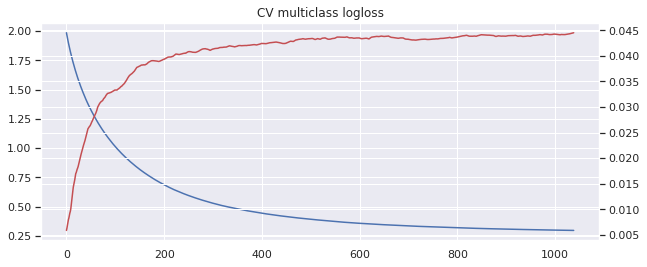

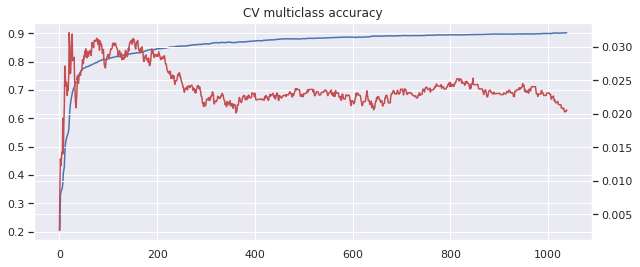

In [51]:
v1, v2 = eval_hist['multi_logloss-mean'][-1], eval_hist['multi_accuracy-mean'][-1]
print("Validation logloss: {:.4f}, accuracy: {:.4f}".format(v1, v2))
plt.figure(figsize=(10, 4))
plt.title("CV multiclass logloss")
num_rounds = len(eval_hist['multi_logloss-mean'])
ax = sns.lineplot(x=range(num_rounds), y=eval_hist['multi_logloss-mean'])
ax2 = ax.twinx()
p = sns.lineplot(x=range(num_rounds), y=eval_hist['multi_logloss-stdv'], ax=ax2, color='r')

plt.figure(figsize=(10, 4))
plt.title("CV multiclass accuracy")
num_rounds = len(eval_hist['multi_accuracy-mean'])
ax = sns.lineplot(x=range(num_rounds), y=eval_hist['multi_accuracy-mean'])
ax2 = ax.twinx()
p = sns.lineplot(x=range(num_rounds), y=eval_hist['multi_accuracy-stdv'], ax=ax2, color='r')

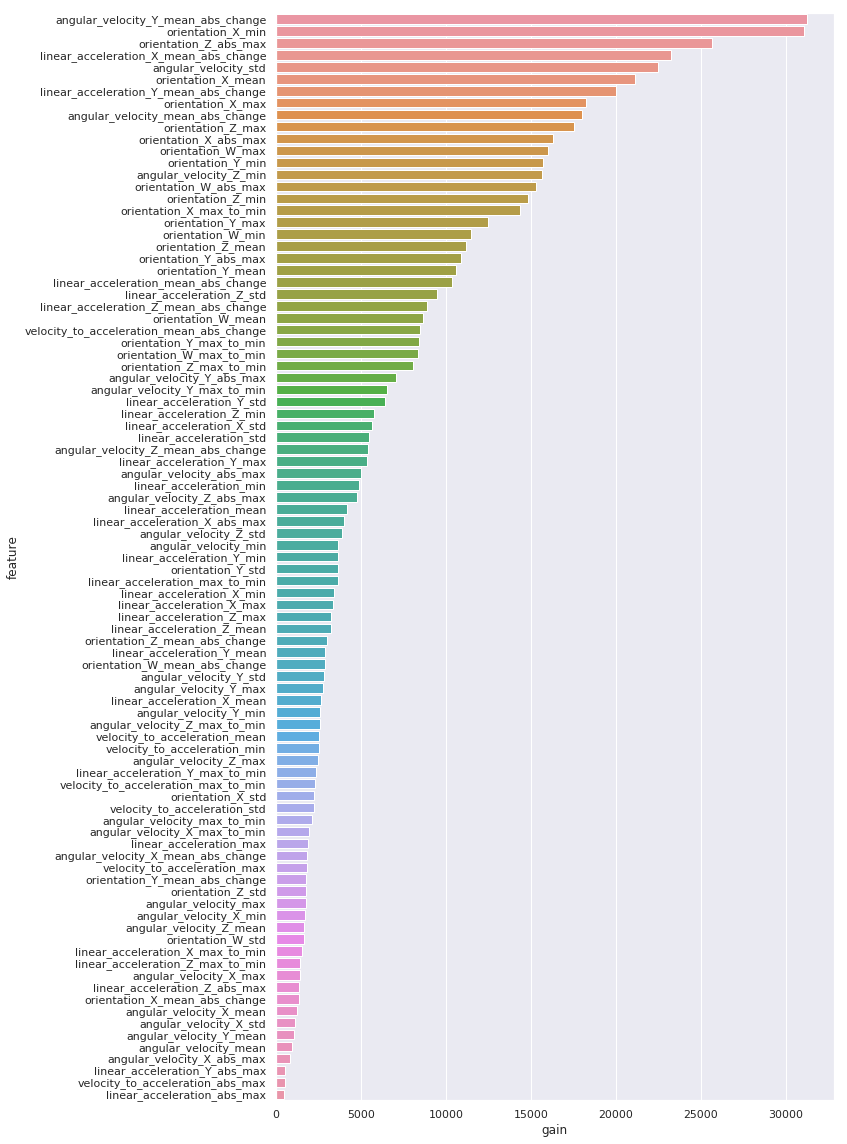

In [52]:
importance = pd.DataFrame({'gain': clf.feature_importance(importance_type='gain'),
                           'feature': clf.feature_name()})
importance.sort_values(by='gain', ascending=False, inplace=True)
plt.figure(figsize=(10, 20))
ax = sns.barplot(x='gain', y='feature', data=importance)

In [53]:
sample_submission['surface'] = le.inverse_transform(predictions.argmax(axis=1))
sample_submission.to_csv('Lgb.csv', index=False)